# About this example

This example shows how you can run the COVID-Net. COVID-Net is a 2D CNN. You can learn more about it on the [COVID-Net repository](https://github.com/lindawangg/COVID-Net).

## Install dependencies

Install the dependencies this example needs.

In [1]:
!pip install -q pillow numpy opencv-python onnxruntime matplotlib

Install the latest version of BlindAI.

In [2]:
!pip install -q blindai

## Upload model to inference server

Download the trained model directly using:

In [3]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Rzl_XpV_kBw-lzu_5xYpc8briFd7fjvc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Rzl_XpV_kBw-lzu_5xYpc8briFd7fjvc" -O COVID-Net-CXR-2.onnx && rm -rf /tmp/cookies.txt

Please make sure the server is running. To launch the server, refer to the [Launching the server](https://docs.mithrilsecurity.io/getting-started/quick-start/run-the-blindai-server) documentation page.

If you wish to run this example in hardware mode, you need to prepare the `host_server.pem` and `policy.toml` files. Learn more on the [Deploy on Hardware](https://docs.mithrilsecurity.io/getting-started/deploy-on-hardware) documentation page. 

In [4]:
from blindai.client import BlindAiClient, ModelDatumType

# Launch client
client = BlindAiClient()

# Simulation mode
client.connect_server(addr="localhost", simulation=True)
# Hardware mode
# client.connect_server(addr="localhost", policy="./policy.toml", certificate="./host_server.pem")

Then, upload the model

In [5]:
client.upload_model(model="./COVID-Net-CXR-2.onnx", shape=(1,480,480,3), dtype=ModelDatumType.F32)

## Send data for prediction

First, we need to fetch the CXR image to send to the model.

In [6]:
!wget --quiet https://raw.githubusercontent.com/lindawangg/COVID-Net/master/assets/ex-covid.jpeg

We will use the same preprocessing functions as in the [COVID-Net repository](https://github.com/lindawangg/COVID-Net).

In [7]:
# This uses OpenCV for image processing
import cv2

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

We can now load the image we have downloaded and preprocess it.

In [8]:
import numpy as np

img = process_image_file("./ex-covid.jpeg", size=480)
img = img.astype("float32") / 255.0
img = img[np.newaxis,:,:,:]

We can have a look at the model input.

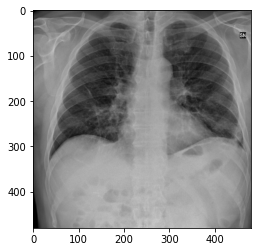

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img[0])

For data marshalling reason, we will flatten the image and convert it to a list.

In [10]:
flattened_img = img.flatten().tolist()

We can then run the model!

In [11]:
response = client.run_model(flattened_img)

[0.012251599691808224, 0.987748384475708]


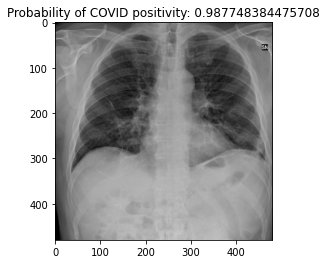

In [12]:
plt.imshow(img[0])
plt.title(f"Probability of COVID positivity: {response.output[1]}")

print(response.output)

Here we can compare the results against the original prediction.

In [13]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("COVID-Net-CXR-2.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: img}

ort_session.run(None, ort_inputs)

[array([[0.01225174, 0.98774827]], dtype=float32)]